In [1]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split


In [2]:
import torch
import torchvision.models as models
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


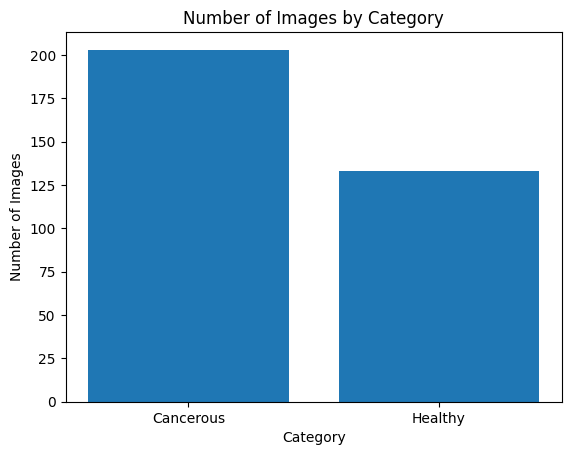

In [41]:
import matplotlib.pyplot as plt

# Replace these numbers with your actual counts
number_of_cancerous_images = 203  # Example count
number_of_healthy_images = 133     # Example count

# Labels for your categories
categories = ['Cancerous', 'Healthy']

# Values corresponding to each category
values = [number_of_cancerous_images, number_of_healthy_images]

# Creating the bar plot
plt.bar(categories, values)

# Adding titles and labels
plt.title('Number of Images by Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')

# Displaying the plot
plt.show()


## ResNet

In [3]:
# Load a pre-trained ResNet model
model = models.resnet50(pretrained=True)

# Freeze all the parameters in the model
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # For binary classification

# Check if a GPU is available and move the model to GPU if it is
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 for ResNet
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization for ResNet
])

# Load your dataset
dataset = datasets.ImageFolder("C:/Users/lenovo/Downloads/Biglycan breast cancer dataset/", transform=transform)

# Splitting dataset into train and validation
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [5]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [6]:
num_epochs = 100  # Define the number of epochs

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero the parameter gradients
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels.unsqueeze(1).type_as(outputs))  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")
    
    # Validation loop can be added here to monitor validation loss and accuracy


Epoch 1, Loss: 0.7290124371647835
Epoch 2, Loss: 0.6313061565160751
Epoch 3, Loss: 0.555512048304081
Epoch 4, Loss: 0.5177107155323029
Epoch 5, Loss: 0.4701675958931446
Epoch 6, Loss: 0.44719403237104416
Epoch 7, Loss: 0.40705810487270355
Epoch 8, Loss: 0.3913630433380604
Epoch 9, Loss: 0.3757568448781967
Epoch 10, Loss: 0.3611692078411579
Epoch 11, Loss: 0.3345712088048458
Epoch 12, Loss: 0.31701556220650673
Epoch 13, Loss: 0.3297787085175514
Epoch 14, Loss: 0.30899257212877274
Epoch 15, Loss: 0.2997094988822937
Epoch 16, Loss: 0.2935173325240612
Epoch 17, Loss: 0.2946882750838995
Epoch 18, Loss: 0.27072738483548164
Epoch 19, Loss: 0.28670958802103996
Epoch 20, Loss: 0.27810963802039623
Epoch 21, Loss: 0.2902575936168432
Epoch 22, Loss: 0.2591111622750759
Epoch 23, Loss: 0.24639404565095901
Epoch 24, Loss: 0.24084755592048168
Epoch 25, Loss: 0.23276295140385628
Epoch 26, Loss: 0.2341508287936449
Epoch 27, Loss: 0.22378451377153397
Epoch 28, Loss: 0.22220702841877937
Epoch 29, Loss: 0.

In [7]:
model.eval()  # Set model to evaluation mode
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs) > 0.5
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# Calculate and print the evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(all_targets, np.array(all_preds).flatten()))

print("\nClassification Report:")
print(classification_report(all_targets, np.array(all_preds).flatten(), target_names=['Healthy', 'Cancerous']))


Confusion Matrix:
[[44  4]
 [ 3 33]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.94      0.92      0.93        48
   Cancerous       0.89      0.92      0.90        36

    accuracy                           0.92        84
   macro avg       0.91      0.92      0.92        84
weighted avg       0.92      0.92      0.92        84



In [8]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        # Apply sigmoid since we used BCEWithLogitsLoss
        predicted_probs = torch.sigmoid(outputs)
        
        # Convert probabilities to predicted class (0 or 1)
        predicted = predicted_probs > 0.5
        
        total += labels.size(0)
        correct += (predicted.flatten() == labels).sum().item()

accuracy = correct / total
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 91.67%


## RESNET-- 10 FOLD CROSS VALIDATION

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Define device upfront
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset_path = 'C:/Users/lenovo/Downloads/Biglycan breast cancer dataset/'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

def get_model(device):
    model = models.resnet50(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 1)  # Adjusted for binary classification
    return model.to(device)

def train_model(model, train_loader, criterion, optimizer, device, epochs=50):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)  # Adjust for BCEWithLogitsLoss
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))  # Adjust labels' shape
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        if (epoch+1) % 10 == 0:  # Print every 10 epochs
            print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss / len(train_loader):.4f}')


def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            running_loss += loss.item()
            preds = torch.sigmoid(outputs) > 0.5  # Convert to binary predictions
            # Ensure preds and labels are at least 1D arrays before extending
            all_predictions.extend(np.atleast_1d(preds.squeeze().cpu().numpy()))
            all_labels.extend(np.atleast_1d(labels.cpu().numpy()))

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary')

    avg_loss = running_loss / len(val_loader)
    accuracy = (all_predictions == all_labels).mean() * 100
    print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1_score:.4f}')
    return avg_loss, accuracy, precision, recall, f1_score


# Criterion adjusted for binary classification with a single output unit
criterion = nn.BCEWithLogitsLoss()

k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)

results = []

for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    train_subsampler = Subset(dataset, train_ids)
    val_subsampler = Subset(dataset, val_ids)
    
    train_loader = DataLoader(train_subsampler, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=16)
    
    model = get_model(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Now specifying epochs=100 for training
    train_model(model, train_loader, criterion, optimizer, device, epochs=50)
    
    avg_loss, accuracy, precision, recall, f1_score = evaluate_model(model, val_loader, criterion, device)

    results.append((avg_loss, accuracy, precision, recall, f1_score))


# After all folds are complete, calculate and print the average loss and accuracy across all folds
# After evaluating all folds
avg_loss = np.mean([result[0] for result in results])
avg_accuracy = np.mean([result[1] for result in results])
avg_precision = np.mean([result[2] for result in results])
avg_recall = np.mean([result[3] for result in results])
avg_f1_score = np.mean([result[4] for result in results])

print(f'\nK-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print(f'Average Loss: {avg_loss:.4f}')
print(f'Average Accuracy: {avg_accuracy:.2f}%')
print(f'Average Precision: {avg_precision:.4f}')
print(f'Average Recall: {avg_recall:.4f}')
print(f'Average F1-score: {avg_f1_score:.4f}')


FOLD 0
--------------------------------
Epoch [10/50], Training Loss: 0.3196
Epoch [20/50], Training Loss: 0.2666
Epoch [30/50], Training Loss: 0.2222
Epoch [40/50], Training Loss: 0.1879
Epoch [50/50], Training Loss: 0.2332
Validation Loss: 0.5526, Accuracy: 79.41%, Precision: 0.6842, Recall: 0.9286, F1-score: 0.7879
FOLD 1
--------------------------------
Epoch [10/50], Training Loss: 0.3348
Epoch [20/50], Training Loss: 0.2764
Epoch [30/50], Training Loss: 0.2596
Epoch [40/50], Training Loss: 0.2357
Epoch [50/50], Training Loss: 0.1832
Validation Loss: 0.1796, Accuracy: 94.12%, Precision: 0.9231, Recall: 0.9231, F1-score: 0.9231
FOLD 2
--------------------------------
Epoch [10/50], Training Loss: 0.3615
Epoch [20/50], Training Loss: 0.2675
Epoch [30/50], Training Loss: 0.2457
Epoch [40/50], Training Loss: 0.2045
Epoch [50/50], Training Loss: 0.2098
Validation Loss: 0.3130, Accuracy: 82.35%, Precision: 0.6471, Recall: 1.0000, F1-score: 0.7857
FOLD 3
--------------------------------


## EffecientNet

In [9]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Assuming 'dataset/' is your dataset directory with 'Cancerous' and 'Healthy' subdirectories
dataset = datasets.ImageFolder('C:/Users/lenovo/Downloads/Biglycan breast cancer dataset/', transform=transform)

# Splitting the dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)



In [10]:
# Load a pre-trained EfficientNet-B0 model
model = models.efficientnet_b0(pretrained=True)

# Freeze all the parameters in the model to prevent them from being updated during training
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier layer for binary classification
num_ftrs = model.classifier[1].in_features  # Get the input feature size of the original classifier
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(num_ftrs, 1)  # Binary classification
)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [11]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)  # Optimize only the classifier


In [12]:
num_epochs = 100  # Adjust according to your needs

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).type_as(outputs))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")



Epoch 1, Loss: 0.6601023475329081
Epoch 2, Loss: 0.5709017515182495
Epoch 3, Loss: 0.5013017058372498
Epoch 4, Loss: 0.4579740994506412
Epoch 5, Loss: 0.4136607415146298
Epoch 6, Loss: 0.39018183946609497
Epoch 7, Loss: 0.36962048874961007
Epoch 8, Loss: 0.3469744821389516
Epoch 9, Loss: 0.352952735291587
Epoch 10, Loss: 0.3300986952251858
Epoch 11, Loss: 0.31039397915204364
Epoch 12, Loss: 0.32183920509285396
Epoch 13, Loss: 0.3050554063585069
Epoch 14, Loss: 0.2975093358092838
Epoch 15, Loss: 0.3112492693795098
Epoch 16, Loss: 0.2828032755189472
Epoch 17, Loss: 0.265971377491951
Epoch 18, Loss: 0.2495581954717636
Epoch 19, Loss: 0.24754688640435538
Epoch 20, Loss: 0.25602660907639396
Epoch 21, Loss: 0.22781111962265438
Epoch 22, Loss: 0.24004303415616354
Epoch 23, Loss: 0.22400512297948202
Epoch 24, Loss: 0.2348979479736752
Epoch 25, Loss: 0.2440014680226644
Epoch 26, Loss: 0.23362939556439719
Epoch 27, Loss: 0.22234112521012625
Epoch 28, Loss: 0.22051024436950684
Epoch 29, Loss: 0.2

In [13]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        # Apply sigmoid since we used BCEWithLogitsLoss
        predicted_probs = torch.sigmoid(outputs)
        
        # Convert probabilities to predicted class (0 or 1)
        predicted = predicted_probs > 0.5
        
        total += labels.size(0)
        correct += (predicted.flatten() == labels).sum().item()

accuracy = correct / total
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 86.76%


In [14]:
model.eval()  # Set model to evaluation mode
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs) > 0.5
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# Calculate and print the evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(all_targets, np.array(all_preds).flatten()))

print("\nClassification Report:")
print(classification_report(all_targets, np.array(all_preds).flatten(), target_names=['Healthy', 'Cancerous']))

Confusion Matrix:
[[34  5]
 [ 4 25]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.89      0.87      0.88        39
   Cancerous       0.83      0.86      0.85        29

    accuracy                           0.87        68
   macro avg       0.86      0.87      0.87        68
weighted avg       0.87      0.87      0.87        68



## EfficientNet- 10 Fold Cross Validation

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Define device upfront
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset_path = 'C:/Users/lenovo/Downloads/Biglycan breast cancer dataset/'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

def get_model(device):
    # Load the pretrained EfficientNet_B0 model
    model = models.efficientnet_b0(pretrained=True)

    # Freeze all the parameters in the model to prevent them from being updated during training
    for param in model.parameters():
        param.requires_grad = False

    # Replace the classifier layer for binary classification
    # Note: Ensure you are accessing the correct layer for modification,
    # EfficientNet_B0's classifier might have a different structure in future torchvision releases
    num_ftrs = model.classifier[1].in_features  # Get the input feature size of the original classifier
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),  # Dropout layer for regularization
        nn.Linear(num_ftrs, 1)  # Adjusted for binary classification
    )

    # Move the model to the specified device (GPU or CPU)
    return model.to(device)

def train_model(model, train_loader, criterion, optimizer, device, epochs=50):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)  # Adjust for BCEWithLogitsLoss
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))  # Adjust labels' shape
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        if (epoch+1) % 10 == 0:  # Print every 10 epochs
            print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss / len(train_loader):.4f}')


def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            running_loss += loss.item()
            preds = torch.sigmoid(outputs) > 0.5  # Convert to binary predictions
            # Ensure preds and labels are at least 1D arrays before extending
            all_predictions.extend(np.atleast_1d(preds.squeeze().cpu().numpy()))
            all_labels.extend(np.atleast_1d(labels.cpu().numpy()))

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary')

    avg_loss = running_loss / len(val_loader)
    accuracy = (all_predictions == all_labels).mean() * 100
    print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1_score:.4f}')
    return avg_loss, accuracy, precision, recall, f1_score


# Criterion adjusted for binary classification with a single output unit
criterion = nn.BCEWithLogitsLoss()

k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)

results = []

for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    train_subsampler = Subset(dataset, train_ids)
    val_subsampler = Subset(dataset, val_ids)
    
    train_loader = DataLoader(train_subsampler, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=16)
    
    model = get_model(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Now specifying epochs=100 for training
    train_model(model, train_loader, criterion, optimizer, device, epochs=50)
    
    avg_loss, accuracy, precision, recall, f1_score = evaluate_model(model, val_loader, criterion, device)

    results.append((avg_loss, accuracy, precision, recall, f1_score))


# After all folds are complete, calculate and print the average loss and accuracy across all folds
# After evaluating all folds
avg_loss = np.mean([result[0] for result in results])
avg_accuracy = np.mean([result[1] for result in results])
avg_precision = np.mean([result[2] for result in results])
avg_recall = np.mean([result[3] for result in results])
avg_f1_score = np.mean([result[4] for result in results])

print(f'\nK-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print(f'Average Loss: {avg_loss:.4f}')
print(f'Average Accuracy: {avg_accuracy:.2f}%')
print(f'Average Precision: {avg_precision:.4f}')
print(f'Average Recall: {avg_recall:.4f}')
print(f'Average F1-score: {avg_f1_score:.4f}')


FOLD 0
--------------------------------
Epoch [10/50], Training Loss: 0.3584
Epoch [20/50], Training Loss: 0.2559
Epoch [30/50], Training Loss: 0.2750
Epoch [40/50], Training Loss: 0.2221
Epoch [50/50], Training Loss: 0.2171
Validation Loss: 0.2391, Accuracy: 97.06%, Precision: 1.0000, Recall: 0.9333, F1-score: 0.9655
FOLD 1
--------------------------------
Epoch [10/50], Training Loss: 0.3336
Epoch [20/50], Training Loss: 0.2807
Epoch [30/50], Training Loss: 0.2261
Epoch [40/50], Training Loss: 0.2296
Epoch [50/50], Training Loss: 0.1673
Validation Loss: 0.2607, Accuracy: 85.29%, Precision: 0.9000, Recall: 0.6923, F1-score: 0.7826
FOLD 2
--------------------------------
Epoch [10/50], Training Loss: 0.3473
Epoch [20/50], Training Loss: 0.2883
Epoch [30/50], Training Loss: 0.2485
Epoch [40/50], Training Loss: 0.2096
Epoch [50/50], Training Loss: 0.1849
Validation Loss: 0.4383, Accuracy: 91.18%, Precision: 0.8571, Recall: 0.9231, F1-score: 0.8889
FOLD 3
--------------------------------


## My algorithm

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BinaryClassificationCNN(nn.Module):
    def __init__(self):
        super(BinaryClassificationCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 14 * 14, 512)  # Adjust the size according to your input image size
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 256 * 14 * 14)  # Flatten the output for the dense layer
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)  # No activation, nn.BCEWithLogitsLoss applies it internally
        return x


In [4]:
import torch
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Assuming the BinaryClassificationCNN class definition is already provided

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit the model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = datasets.ImageFolder('C:/Users/lenovo/Downloads/Biglycan breast cancer dataset/', transform=transform)

# Splitting dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)



In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BinaryClassificationCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [6]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()  # Ensure labels are float
        
        optimizer.zero_grad()  # Zero the gradients
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs.squeeze(), labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize
        
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')
    
    # Optional: Add validation loop here


Epoch 1/50, Loss: 7.853662808736165
Epoch 2/50, Loss: 1.427810827891032
Epoch 3/50, Loss: 1.4601164327727423
Epoch 4/50, Loss: 0.9993891484207578
Epoch 5/50, Loss: 0.726152628660202
Epoch 6/50, Loss: 0.5077841861380471
Epoch 7/50, Loss: 0.4611706460515658
Epoch 8/50, Loss: 0.3107933923602104
Epoch 9/50, Loss: 0.22966955105463663
Epoch 10/50, Loss: 0.41189462774329716
Epoch 11/50, Loss: 0.27967242565419936
Epoch 12/50, Loss: 0.4948378668891059
Epoch 13/50, Loss: 0.25884318517314064
Epoch 14/50, Loss: 0.34087637149625355
Epoch 15/50, Loss: 0.22077318363719517
Epoch 16/50, Loss: 0.7030209203561147
Epoch 17/50, Loss: 0.25538038048479295
Epoch 18/50, Loss: 0.3219006293349796
Epoch 19/50, Loss: 0.3904445353481505
Epoch 20/50, Loss: 0.3962450789080726
Epoch 21/50, Loss: 0.18524051871564653
Epoch 22/50, Loss: 0.1546869476636251
Epoch 23/50, Loss: 0.13482591344250572
Epoch 24/50, Loss: 0.11191048183374935
Epoch 25/50, Loss: 0.1337103827132119
Epoch 26/50, Loss: 0.14352568445934188
Epoch 27/50, 

In [7]:
model.eval()  # Set the model to evaluation mode
val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        outputs = model(inputs)
        
        loss = criterion(outputs.squeeze(), labels)
        val_loss += loss.item()
        
        predicted = torch.sigmoid(outputs).squeeze() > 0.5  # Apply sigmoid and threshold
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f'Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100 * correct / total}%')


Validation Loss: 0.6674602627754211, Accuracy: 85.29411764705883%


In [8]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Ensure the model is in evaluation mode
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, labels in val_loader:  # Assuming val_loader is your DataLoader for the validation set
        inputs = inputs.to(device)
        outputs = model(inputs)
        
        # Convert outputs to predicted class (0 or 1) using a threshold of 0.5
        preds = torch.sigmoid(outputs).squeeze() > 0.5
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# Convert lists to numpy arrays for sklearn
all_preds = np.array(all_preds, dtype=int)
all_targets = np.array(all_targets, dtype=int)


In [9]:
cm = confusion_matrix(all_targets, all_preds)
print(cm)


[[33  3]
 [ 7 25]]


In [10]:
model.eval()  # Set model to evaluation mode
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs) > 0.5
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# Calculate and print the evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(all_targets, np.array(all_preds).flatten()))

print("\nClassification Report:")
print(classification_report(all_targets, np.array(all_preds).flatten(), target_names=['Healthy', 'Cancerous']))

Confusion Matrix:
[[33  3]
 [ 7 25]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.82      0.92      0.87        36
   Cancerous       0.89      0.78      0.83        32

    accuracy                           0.85        68
   macro avg       0.86      0.85      0.85        68
weighted avg       0.86      0.85      0.85        68



In [14]:
from PIL import Image
from torchvision import transforms

# Define the preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Load your image (replace 'path_to_your_image.jpg' with the actual file path)
img_path = "C:/Users/lenovo/Downloads/Biglycan breast cancer dataset/CANCER/12239 (12) (1).png"
img = Image.open(img_path).convert("RGB")

# Apply the preprocessing to the image
input_tensor = transform(img)

# Add a batch dimension (B, C, H, W), where B = 1
input_tensor = input_tensor.unsqueeze(0)

# Now, input_tensor is ready to be passed into your model


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import cv2

# 

def apply_gradcam(input_image_path, model, target_layer):
    # Preprocessing
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load and preprocess the image
    img = Image.open(input_image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    # Forward pass for the model to get logits
    model.eval()
    logits = model(img_tensor)

    # Backward pass for gradient calculation
    target = logits  # Assuming binary classification and single output neuron
    model.zero_grad()
    target.backward()

    # Extract activations and gradients from the target layer
    gradients = target_layer.gradients  # Assuming you've implemented gradient capture
    activations = target_layer.activations  # Assuming you've implemented activation capture

    # Pool the gradients across the channels and weight the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(gradients.shape[1]):  # Number of channels
        activations[:, i, :, :] *= pooled_gradients[i]

    # Generate the heatmap
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap.detach().cpu().numpy(), 0)
    heatmap /= np.max(heatmap)

    # Resize the heatmap to the original image size
    heatmap = cv2.resize(heatmap, (img.width, img.height))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on original image
    superimposed_img = heatmap * 0.4 + np.array(img)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    # Display the image
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Initialize your model
model = BinaryClassificationCNN()

# Example usage
input_image_path = 'C:/Users/lenovo/Downloads/Biglycan breast cancer dataset/CANCER/12239 (12) (1).png'
target_layer = model.conv4  # Assuming you want to use the last conv layer
apply_gradcam(input_image_path, model, target_layer)


AttributeError: 'Conv2d' object has no attribute 'gradients'

In [29]:
train_size

268

In [30]:
val_size

68

## Hyperparameter Tuning

In [23]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Setup dataset (adjust path as necessary)
data_folder = 'C:/Users/lenovo/Downloads/Biglycan breast cancer dataset/'
full_dataset = datasets.ImageFolder(root=data_folder, transform=transform)

# Split dataset
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64]

best_accuracy = 0
best_params = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Training with LR: {lr}, Batch Size: {batch_size}")

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        model = BinaryClassificationCNN().to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Simplified training loop
        for epoch in range(10):  # Let's limit to 3 epochs for brevity
            model.train()
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Simplified validation loop
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(inputs)
                predicted = torch.sigmoid(outputs).squeeze() > 0.5
                total += labels.size(0)
                correct += (predicted == labels.squeeze()).sum().item()

        accuracy = correct / total
        print(f"Validation Accuracy: {accuracy}")

        # Track the best parameters
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'lr': lr, 'batch_size': batch_size}

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Parameters: {best_params}")


Training with LR: 0.01, Batch Size: 16
Validation Accuracy: 0.7941176470588235
Training with LR: 0.01, Batch Size: 32
Validation Accuracy: 0.7941176470588235
Training with LR: 0.01, Batch Size: 64
Validation Accuracy: 0.8088235294117647
Training with LR: 0.001, Batch Size: 16
Validation Accuracy: 0.7647058823529411
Training with LR: 0.001, Batch Size: 32
Validation Accuracy: 0.7058823529411765
Training with LR: 0.001, Batch Size: 64
Validation Accuracy: 0.7941176470588235
Training with LR: 0.0001, Batch Size: 16
Validation Accuracy: 0.8382352941176471
Training with LR: 0.0001, Batch Size: 32
Validation Accuracy: 0.8088235294117647
Training with LR: 0.0001, Batch Size: 64
Validation Accuracy: 0.7794117647058824
Best Accuracy: 0.8382352941176471
Best Parameters: {'lr': 0.0001, 'batch_size': 16}


## Proposed Algorithm - 10 Fold Cross Validation

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Define device upfront
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset_path = 'C:/Users/lenovo/Downloads/Biglycan breast cancer dataset/'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

def get_model(device):
    # Assuming BinaryClassificationCNN is a previously defined model for binary classification
    model = BinaryClassificationCNN()  # Use your model here
    return model.to(device)

def train_model(model, train_loader, criterion, optimizer, device, epochs=50):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)  # Adjust for BCEWithLogitsLoss
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))  # Adjust labels' shape
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        if (epoch+1) % 10 == 0:  # Print every 10 epochs
            print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss / len(train_loader):.4f}')

def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            running_loss += loss.item()
            preds = torch.sigmoid(outputs) > 0.5  # Convert to binary predictions
            # Ensure preds and labels are at least 1D arrays before extending
            all_predictions.extend(np.atleast_1d(preds.squeeze().cpu().numpy()))
            all_labels.extend(np.atleast_1d(labels.cpu().numpy()))

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary')

    avg_loss = running_loss / len(val_loader)
    accuracy = (all_predictions == all_labels).mean() * 100
    print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1_score:.4f}')
    return avg_loss, accuracy, precision, recall, f1_score


# Criterion adjusted for binary classification with a single output unit
criterion = nn.BCEWithLogitsLoss()

k_folds = 10  # Change from 5 to 10 for 10-fold cross-validation
kfold = KFold(n_splits=k_folds, shuffle=True)

results = []

for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    train_subsampler = Subset(dataset, train_ids)
    val_subsampler = Subset(dataset, val_ids)
    
    train_loader = DataLoader(train_subsampler, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=16)
    
    model = get_model(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    train_model(model, train_loader, criterion, optimizer, device, epochs=50)
    
    avg_loss, accuracy, precision, recall, f1_score = evaluate_model(model, val_loader, criterion, device)

    results.append((avg_loss, accuracy, precision, recall, f1_score))

avg_loss = np.mean([result[0] for result in results])
avg_accuracy = np.mean([result[1] for result in results])
avg_precision = np.mean([result[2] for result in results])
avg_recall = np.mean([result[3] for result in results])
avg_f1_score = np.mean([result[4] for result in results])

print(f'\nK-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print(f'Average Loss: {avg_loss:.4f}')
print(f'Average Accuracy: {avg_accuracy:.2f}%')
print(f'Average Precision: {avg_precision:.4f}')
print(f'Average Recall: {avg_recall:.4f}')
print(f'Average F1-score: {avg_f1_score:.4f}')


FOLD 0
--------------------------------
Epoch [10/50], Training Loss: 0.1936
Epoch [20/50], Training Loss: 0.0470
Epoch [30/50], Training Loss: 0.0132
Epoch [40/50], Training Loss: 0.0055
Epoch [50/50], Training Loss: 0.0042
Validation Loss: 0.2437, Accuracy: 94.12%, Precision: 0.9000, Recall: 0.9000, F1-score: 0.9000
FOLD 1
--------------------------------
Epoch [10/50], Training Loss: 0.1656
Epoch [20/50], Training Loss: 0.0478
Epoch [30/50], Training Loss: 0.0176
Epoch [40/50], Training Loss: 0.0173
Epoch [50/50], Training Loss: 0.0384
Validation Loss: 0.1486, Accuracy: 88.24%, Precision: 0.7857, Recall: 0.9167, F1-score: 0.8462
FOLD 2
--------------------------------
Epoch [10/50], Training Loss: 0.2644
Epoch [20/50], Training Loss: 0.1917
Epoch [30/50], Training Loss: 0.0558
Epoch [40/50], Training Loss: 0.0198
Epoch [50/50], Training Loss: 0.0042
Validation Loss: 0.2674, Accuracy: 88.24%, Precision: 0.8333, Recall: 0.9375, F1-score: 0.8824
FOLD 3
--------------------------------


In [30]:
import torch
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Assuming the BinaryClassificationCNN class definition is already provided

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit the model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = datasets.ImageFolder('C:/Users/lenovo/Downloads/Biglycan breast cancer dataset/', transform=transform)

# Splitting dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BinaryClassificationCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [32]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()  # Ensure labels are float
        
        optimizer.zero_grad()  # Zero the gradients
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs.squeeze(), labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize
        
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')
    
    # Optional: Add validation loop here

Epoch 1/50, Loss: 1.0769436306813185
Epoch 2/50, Loss: 0.6144414947313421
Epoch 3/50, Loss: 0.40919125868993644
Epoch 4/50, Loss: 0.3396902281571837
Epoch 5/50, Loss: 0.22093496427816503
Epoch 6/50, Loss: 0.4640796416822602
Epoch 7/50, Loss: 0.3449540493242881
Epoch 8/50, Loss: 0.3492835788604091
Epoch 9/50, Loss: 0.2295837213887888
Epoch 10/50, Loss: 0.18509838401394732
Epoch 11/50, Loss: 0.11074921138146344
Epoch 12/50, Loss: 0.07471664753906868
Epoch 13/50, Loss: 0.15359422860338406
Epoch 14/50, Loss: 0.1080382815836107
Epoch 15/50, Loss: 0.1252198898616959
Epoch 16/50, Loss: 0.07184543551000602
Epoch 17/50, Loss: 0.06040382077095702
Epoch 18/50, Loss: 0.04487014518064611
Epoch 19/50, Loss: 0.0573450575774426
Epoch 20/50, Loss: 0.031196470125852263
Epoch 21/50, Loss: 0.03690545968985295
Epoch 22/50, Loss: 0.022597969879451042
Epoch 23/50, Loss: 0.015890615786809253
Epoch 24/50, Loss: 0.02467205191907637
Epoch 25/50, Loss: 0.018207409268464234
Epoch 26/50, Loss: 0.01874736654024352
E

In [33]:
 model.eval()  # Set the model to evaluation mode
val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        outputs = model(inputs)
        
        loss = criterion(outputs.squeeze(), labels)
        val_loss += loss.item()
        
        predicted = torch.sigmoid(outputs).squeeze() > 0.5  # Apply sigmoid and threshold
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f'Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100 * correct / total}%')


Validation Loss: 0.49687231332063675, Accuracy: 83.82352941176471%


In [34]:
model.eval()  # Set model to evaluation mode
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs) > 0.5
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# Calculate and print the evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(all_targets, np.array(all_preds).flatten()))

print("\nClassification Report:")
print(classification_report(all_targets, np.array(all_preds).flatten(), target_names=['Healthy', 'Cancerous']))

Confusion Matrix:
[[44  6]
 [ 5 13]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.90      0.88      0.89        50
   Cancerous       0.68      0.72      0.70        18

    accuracy                           0.84        68
   macro avg       0.79      0.80      0.80        68
weighted avg       0.84      0.84      0.84        68



## MobileNet

In [35]:
def create_model(num_classes=2):
    # Load a pre-trained MobileNetV2 model
    model = models.mobilenet_v2(pretrained=True)
    
    # Modify the classifier to fit the number of classes
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    
    # If binary classification, change the output layer to a single unit with sigmoid activation
    if num_classes == 2:
        model.classifier[1] = nn.Linear(model.last_channel, 1)
    
    return model

model = create_model(num_classes=1)  # For binary classification


In [36]:
import torch
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Assuming the BinaryClassificationCNN class definition is already provided

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit the model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = datasets.ImageFolder('C:/Users/lenovo/Downloads/Biglycan breast cancer dataset/', transform=transform)

# Splitting dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = create_model().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [38]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()  # Ensure labels are float
        
        optimizer.zero_grad()  # Zero the gradients
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs.squeeze(), labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize
        
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')
    

Epoch 1/50, Loss: 0.5349482788759119
Epoch 2/50, Loss: 0.22295346943771138
Epoch 3/50, Loss: 0.09588757946210749
Epoch 4/50, Loss: 0.062006058500093574
Epoch 5/50, Loss: 0.03620221071383532
Epoch 6/50, Loss: 0.02118881290559383
Epoch 7/50, Loss: 0.019684750805882847
Epoch 8/50, Loss: 0.0235219247337869
Epoch 9/50, Loss: 0.025950317764106917
Epoch 10/50, Loss: 0.014860485159956357
Epoch 11/50, Loss: 0.030102890594314563
Epoch 12/50, Loss: 0.0595970931052066
Epoch 13/50, Loss: 0.06659441713846344
Epoch 14/50, Loss: 0.05088220488773111
Epoch 15/50, Loss: 0.04401427942930775
Epoch 16/50, Loss: 0.03336102479164872
Epoch 17/50, Loss: 0.013831479221527629
Epoch 18/50, Loss: 0.010874828025835621
Epoch 19/50, Loss: 0.009696896910420893
Epoch 20/50, Loss: 0.03736421662752571
Epoch 21/50, Loss: 0.01739040335215738
Epoch 22/50, Loss: 0.03978815864470294
Epoch 23/50, Loss: 0.014711701235843493
Epoch 24/50, Loss: 0.013089327535400277
Epoch 25/50, Loss: 0.013992316712734891
Epoch 26/50, Loss: 0.09869

In [39]:
model.eval()  # Set the model to evaluation mode
val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        outputs = model(inputs)
        
        loss = criterion(outputs.squeeze(), labels)
        val_loss += loss.item()
        
        predicted = torch.sigmoid(outputs).squeeze() > 0.5  # Apply sigmoid and threshold
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f'Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100 * correct / total}%')


Validation Loss: 0.2368245217949152, Accuracy: 91.17647058823529%


In [40]:
model.eval()  # Set model to evaluation mode
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs) > 0.5
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# Calculate and print the evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(all_targets, np.array(all_preds).flatten()))

print("\nClassification Report:")
print(classification_report(all_targets, np.array(all_preds).flatten(), target_names=['Healthy', 'Cancerous']))

Confusion Matrix:
[[36  1]
 [ 5 26]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.88      0.97      0.92        37
   Cancerous       0.96      0.84      0.90        31

    accuracy                           0.91        68
   macro avg       0.92      0.91      0.91        68
weighted avg       0.92      0.91      0.91        68



## MobileNet-10 Fold Cross Validation

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import numpy as np

# Define device upfront
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset_path = 'C:/Users/lenovo/Downloads/Biglycan breast cancer dataset/'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

def get_model(device):
    model = create_model()  # Use your model here
    return model.to(device)

def train_model(model, train_loader, criterion, optimizer, device, epochs=50):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)  # Adjust for BCEWithLogitsLoss
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))  # Adjust labels' shape
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        if (epoch+1) % 10 == 0:  # Print every 10 epochs
            print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss / len(train_loader):.4f}')


def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            running_loss += loss.item()
            preds = torch.sigmoid(outputs) > 0.5  # Convert to binary predictions
            # Ensure preds and labels are at least 1D arrays before extending
            all_predictions.extend(np.atleast_1d(preds.squeeze().cpu().numpy()))
            all_labels.extend(np.atleast_1d(labels.cpu().numpy()))

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary')

    avg_loss = running_loss / len(val_loader)
    accuracy = (all_predictions == all_labels).mean() * 100
    print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1_score:.4f}')
    return avg_loss, accuracy, precision, recall, f1_score


# Criterion adjusted for binary classification with a single output unit
criterion = nn.BCEWithLogitsLoss()

k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)

results = []

for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    train_subsampler = Subset(dataset, train_ids)
    val_subsampler = Subset(dataset, val_ids)
    
    train_loader = DataLoader(train_subsampler, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=16)
    
    model = get_model(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Now specifying epochs=100 for training
    train_model(model, train_loader, criterion, optimizer, device, epochs=50)
    
    avg_loss, accuracy, precision, recall, f1_score = evaluate_model(model, val_loader, criterion, device)

    results.append((avg_loss, accuracy, precision, recall, f1_score))


# After all folds are complete, calculate and print the average loss and accuracy across all folds
# After evaluating all folds
avg_loss = np.mean([result[0] for result in results])
avg_accuracy = np.mean([result[1] for result in results])
avg_precision = np.mean([result[2] for result in results])
avg_recall = np.mean([result[3] for result in results])
avg_f1_score = np.mean([result[4] for result in results])

print(f'\nK-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print(f'Average Loss: {avg_loss:.4f}')
print(f'Average Accuracy: {avg_accuracy:.2f}%')
print(f'Average Precision: {avg_precision:.4f}')
print(f'Average Recall: {avg_recall:.4f}')
print(f'Average F1-score: {avg_f1_score:.4f}')



FOLD 0
--------------------------------
Epoch [10/50], Training Loss: 0.0414
Epoch [20/50], Training Loss: 0.0501
Epoch [30/50], Training Loss: 0.0614
Epoch [40/50], Training Loss: 0.0176
Epoch [50/50], Training Loss: 0.0230
Validation Loss: 0.5249, Accuracy: 79.41%, Precision: 0.6875, Recall: 0.8462, F1-score: 0.7586
FOLD 1
--------------------------------
Epoch [10/50], Training Loss: 0.1072
Epoch [20/50], Training Loss: 0.0604
Epoch [30/50], Training Loss: 0.0041
Epoch [40/50], Training Loss: 0.0780
Epoch [50/50], Training Loss: 0.0566
Validation Loss: 0.2398, Accuracy: 91.18%, Precision: 0.7857, Recall: 1.0000, F1-score: 0.8800
FOLD 2
--------------------------------
Epoch [10/50], Training Loss: 0.1335
Epoch [20/50], Training Loss: 0.0646
Epoch [30/50], Training Loss: 0.0060
Epoch [40/50], Training Loss: 0.0938
Epoch [50/50], Training Loss: 0.0094
Validation Loss: 0.3891, Accuracy: 82.35%, Precision: 0.7692, Recall: 0.7692, F1-score: 0.7692
FOLD 3
--------------------------------
